In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Subset

import matplotlib.pyplot as plt

from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

/Users/philipfredriksz/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/philipfredriksz/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <00B86D22-833F-3522-B9CF-FCA5ED5567DC> /Users/philipfredriksz/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <51359D84-6AD7-3580-B6FC-DD9B642AEA0E> /Users/philipfredriksz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using mps device


In [2]:
# Define the transform with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing the images with mean 0.5 and std 0.5
])

# Load the full training and test datasets
full_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=transform
)

full_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=transform
)

# Define the number of samples you want to use
num_train_samples = 1000
num_test_samples = 200

# Create subsets of the data
train_indices = np.random.choice(len(full_training_data), num_train_samples, replace=False)
test_indices = np.random.choice(len(full_test_data), num_test_samples, replace=False)

training_data = Subset(full_training_data, train_indices)
test_data = Subset(full_test_data, test_indices)

# Create data loaders
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# Check the dtype of the images
sample_image, _ = next(iter(train_dataloader))
print(f"Training data sample dtype: {sample_image.dtype}")

sample_image, _ = next(iter(test_dataloader))
print(f"Test data sample dtype: {sample_image.dtype}")

Training data sample dtype: torch.float32
Test data sample dtype: torch.float32


In [3]:
len(test_data)

200

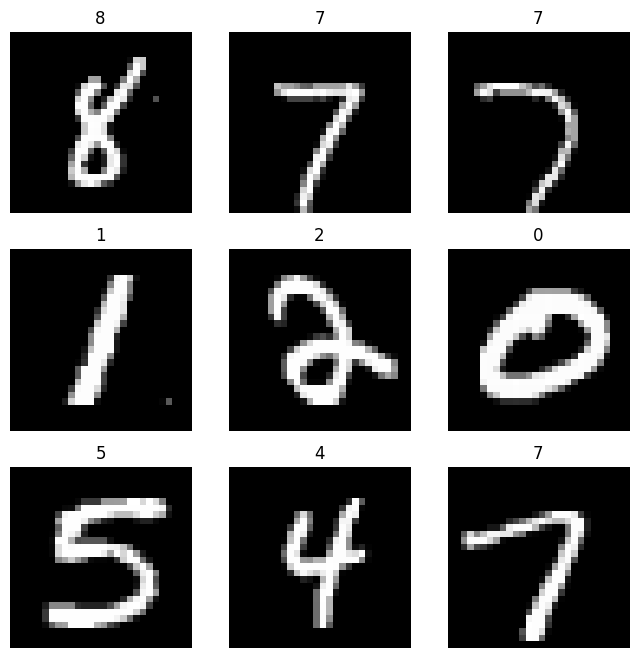

In [4]:
labels_map = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



# Build Model #

### This time build autoencoder with convolutional Layers


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size=3, stride=2,padding=1),
                        nn.ReLU())
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size=3, stride=2,padding=1),
                        nn.ReLU())
        self.dense = nn.Sequential(
                        nn.Linear(3136,2),
                        nn.ReLU())
        
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.conv1(x) # Output shape: torch.Size([1, 32, 14, 14])
        x = self.conv2(x) # Output shape: torch.Size([1, 64, 7, 7])

        x = self.flatten(x) # Output shape: torch.Size([1, 3136])

        x = self.dense(x) # Output shape: torch.Size([1, 2])

        return(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(2,3136),
            nn.ReLU()
        )
        self.transpconv1 = nn.Sequential(
                    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1),
                    nn.ReLU()

        )
        self.transpconv2 = nn.Sequential(
                    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1),
                    nn.ReLU()

        )
        self.output = nn.Sequential(
                    nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1,padding=0),
                    nn.Sigmoid())

    
    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, 64, 7, 7 ) # Output shape: torch.Size([1, 64, 7, 7])
        x = self.transpconv1(x) # Output shape: torch.Size([1, 32, 14, 14])

        x = self.transpconv2(x) # Output shape: torch.Size([1, 32, 28, 28])
        x = self.output(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encode = Encoder()
        self.decode = Decoder()


    def forward(self, x, return_latent=False):
        if return_latent:
            x = self.encode(x)
            latent = x.clone()
            x = self.decode(x)
            return x, latent
        else:
            x = self.encode(x)
            x = self.decode(x)
            return x


encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder() 

random_tensor = torch.randn(8,1,28,28)

latent_test = encoder(random_tensor)
output_test = decoder(latent_test)

whole_test = autoencoder(random_tensor)
print(latent_test.shape)


torch.Size([8, 2])


torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


Text(0.5, 1.0, 'Model Output (untrained)')

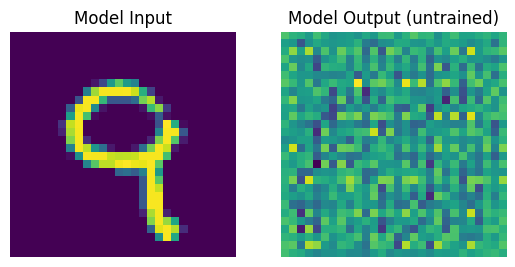

In [6]:
autoencoder = AutoEncoder() 

test_img, test_label = test_data[0]

print(test_img.shape)

test_pred = autoencoder(test_img.unsqueeze(0))

print(test_pred.shape)

fix,ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(np.array(test_img)))
ax[0].axis('off')
ax[0].set_title('Model Input')

ax[1].imshow(np.squeeze(test_pred.detach().numpy()))
ax[1].axis('off')
ax[1].set_title('Model Output (untrained)')




In [7]:
import torch
from torch import nn, optim

# Ensure model is on the correct device
autoencoder.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0
    for images, _ in train_dataloader:
        images = images.to(device)
        
        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

print("Training complete.")


Epoch [1/10], Loss: 0.9340
Epoch [2/10], Loss: 0.9256
Epoch [3/10], Loss: 0.9256
Epoch [4/10], Loss: 0.9256
Epoch [5/10], Loss: 0.9256
Epoch [6/10], Loss: 0.9256
Epoch [7/10], Loss: 0.9256
Epoch [8/10], Loss: 0.9256
Epoch [9/10], Loss: 0.9256
Epoch [10/10], Loss: 0.9256
Training complete.


In [8]:
print(device)

mps


# Traine Da Model #

In [9]:
learning_rate = 1e-6
epochs = 1
batch_size= 2

loss_fn = nn.MSELoss()

model = AutoEncoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

size = len(train_dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
model.train()

for batch, (X, _) in enumerate(train_dataloader):
    # Compute prediction and loss
    # Move data to the device
    X = X.to(device)
    pred = model(X)
    loss = loss_fn(pred, X)

    # Backpropagation
    loss.backward()

    for param in model.parameters():
        if param.grad is not None:
            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                print(f"Found NaN or inf in gradients for {param}")
                break
    optimizer.step()


    optimizer.zero_grad()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


loss: 2.014663  [    1/ 1000]
loss: 2.021866  [  201/ 1000]
loss: 1.956540  [  401/ 1000]
loss: 1.949059  [  601/ 1000]
loss: 1.815144  [  801/ 1000]
loss: 1.745473  [ 1001/ 1000]
loss: 1.904568  [ 1201/ 1000]
loss: 1.911912  [ 1401/ 1000]
loss: 1.834958  [ 1601/ 1000]
loss: 1.967514  [ 1801/ 1000]


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        # Compute prediction and loss
        # Move data to the device
        X = X.to(device)
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, _ in dataloader:
            # Move data to the device
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X.view(-1,28*28)).item()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


In [11]:
learning_rate = 1e-4
epochs = 1
batch_size= 1

loss = nn.MSELoss()

model = AutoEncoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
    test_loop(test_dataloader, model, loss)
print("Done!")

Epoch 1
-------------------------------
loss: 1.665164  [    1/ 1000]
loss: 0.915238  [  101/ 1000]
loss: 0.940225  [  201/ 1000]
loss: 0.925941  [  301/ 1000]
loss: 0.911220  [  401/ 1000]
loss: 0.961830  [  501/ 1000]
loss: 0.931010  [  601/ 1000]
loss: 0.910218  [  701/ 1000]
loss: 0.901814  [  801/ 1000]
loss: 0.912888  [  901/ 1000]


/Users/philipfredriksz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 784])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (28) must match the size of tensor b (784) at non-singleton dimension 3